# Notebook - MDPI energies - 2021 
# Article *An open source optimisation model generation tool to support energy stakeholders at district scale*
*This notebook has been developed with OMEGAlpes version 0.4.1. It is shared with the licence [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html), Copyright 2018 G2Elab / MAGE*

>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fomegalpes%2Fomegalpes_examples/HEAD?filepath=%2Fnotebooks%2Farticle_2021_MPDI_waste_heat.ipynb)  

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.

***Important note***: the article linked to this notebook is currently in the reviewing process. The OMEGAlpes version 0.4.1. will be released soon. As a result: this notebook can be used in order to observe and understand OMEGAlpes modelling principles, but it cannot be run online at the moment since it needs OMEGAlpes version 0.4.1. to be released. The use case source code is available in OMEGAlpes examples gitlab, and the 0.4.1. OMEGAlpes code is available on OMEGAlpes Gitlab.  

## General introduction

The aim of this notebook is to provide a basis for understanding of the tool OMEGAlpes. This notebook is structured around the presentation of an energy recovery case study. First, the case study is presented, as well as the hypotheses chosen for the modelling of the energy systems. This allows us to present how each element is modelled and then to present a first energy optimisation. Then the different libraries are presented, first the Pareto front elaboration, then the energy library. Then the Actor package is presented with three different scenarios that can be modelled. This highlights the additional modelling possibilities offered by this package. Finally, the use of the infeasible constraints identification module is described.

## Table of contents

* Presentation of the use case : valorisation of waste energy at district level
    * Model equation and simplfying assumptions
    * Operating steps
    * Relevant libraries import
* Operating steps to model the waste heat recovery system
    * Input energy profiles
    * Presentation of the creation of the energy units related to the energy system of the use case
    * Post-treatment assessments
* Pareto chart generator example
* Exergy module
    * Modelisation of the exergy layer
    * Post-treatment assessments
* Actor package
    * Actor scenario for thermal storage assessement 
    * Scenario with a Regulator Actor
    * Scenario introducing a constraint from one actor to another one
* LPFICS package for indentification of infeasible constraints

## Presentation of the use case : valorisation of waste energy at district level

This notebook presents the use example example that is described in the corresponding article. An electro-intensive industrial process consumes electricity and rejects heat. This waste energy is whether recovered or dissipated depending on the waste recovery system sizing. A storage system and a heat pump are used in order to recover the waste energy, which is then injected on a district heat network to provide heat to a district heat load. The missing heat will be provided by a district heat network production unit.

The system includes:

* The electricity grid
* An electro-intensive industry
* A dissipation load
* A thermal storage system
* A heat pump
* A district heat network load
* A district heat network production unit

The figure below shows the waste heat recovery use case and power flow at the district scale.

![Waste heat recovery use case scheme](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/Waste_use_case_general_scheme.png)

The table below gathers all the information considering the energy systems on the waste heat recovery systems:

| Industrial (EII) | District Heat Network Operator (DHNO) |  Electric Supplier (ES) | Recovery System |
|:------------------|:-------------------------------------:|:-----------------------:|:-----------------:|
| Heat production (EII<sup>out</sup>) | Heat production (HS) | Electricity production (ES<sup>out</sup>) | Thermal storage (TS) |
| Electricity consumption (EIIi<sup>in</sup>) | Heat consumption (DHC) | Electricity consumption (ES<sup>in</sup>) | Heat pump (HP) |
| Heat dissipation (DISS) | | | |


### Model equation and simplfying assumptions

In order to facilitate the energy modelling of the case study, the following simplifying assumptions were used:

* All temperature levels remain constant over the year.
* Pressure and heat losses in the pipes are neglected.
* Perfect temperature stratification is assumed within the thermal storage unit. 
* The initial and final states of charge of the thermal storage are identical. 
* A start-up and shut-down time are considered for the heat generation plants connected to the heating network.Pseudo-steady state is assumed at every time step. 

Considering all energy units, we offer  a set of non-stationary energy balances for each unit. For each unit, the balance considers the inlet (Q<sup>in</sup>) and outlet (Q<sup>out</sup>) heat flows, the incoming (W<sup>in</sup>) and outgoing (W<sup>out</sup>) power and the energy storage (ΔU). The table below provides all these energy balance equations as well as additional equations for each energy unit.

![eq_model](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/equation_table.png)

### Operating steps

1. Creating an empty model
2. Creating the unit dedicated to time management
3. Importing time-dependent data from files
4. Creating the electro-intensive industry unit
5. Creating unit for heat dissipation from the industrial process
6. Creating the thermal storage
7. Creating the heat pumpCreating the district heat load
8. Creating the heat production plants
9. Creating the heat node for the energy flows
10. Connecting units to the nodesMinimizing the part of the heat load covered by the heat production plant
11. Adding all nodes (and connected units) to the optimization model
12. Writing into lp fileRunning optimization and update values

### Relevant libraries import

In [118]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from pulp import LpStatus

AttributeError: module 'typing' has no attribute 'NoReturn'

## Operating steps to model the waste heat recovery system

Importing from OMEGAlpes library the model and time classes

In [89]:
from omegalpes.general.optimisation.model import OptimisationModel
from omegalpes.general.time import TimeUnit

Creating a TimeUnit instance dedicated to time management.

* periods parameter fixes the duration of the optimisation within one week
* dt parameter fixes the time step of the optimisation to one hour

In [90]:
time = TimeUnit(periods=24 * 7, dt=1)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00


Creating an empty model

In [91]:
# Creating an empty model
model = OptimisationModel(time=time, name='waste_heat_recovery_model')

Defining the input data for instanciation of the energy units

In [92]:
WORK_PATH = os.getcwd()
SCENARIO = None # either A_dissipation or A_CO2 (prosumer) or B_minproduction or B_shift (operator)
OBJ = "energy"  # either energy_model, energy, exergy or actors

# --- Time Schedule for thermal grid operator ---
# Define the hour when the peak of thermal consumpation are foreseen
MAX_PEAK_SCHEDULE = [6, 7, 8, 18, 19, 20, 21]

# --- Electricity-to-Thermal conversion ---
# 90% of the electrical consumption is converted into heat
ELEC_TO_HEAT_RATIO = 0.9

CAPA_STORAGE = 25000 # Storage capacity of 25MWh
SOC_0_STORAGE = None  # Initial state of charge of 10%

# --- Thermal storage parameters ---
# The maximal charging and discharging powers both equal 5 MW
PC_MAX_STORAGE = PD_MAX_STORAGE = CAPA_STORAGE / 3

# When charging/discharging, the power should at least be 20% of the
# maximal charging/discharging powers
PC_MIN_STORAGE = PD_MIN_STORAGE = 0.05 * PC_MAX_STORAGE

# --- Heat pump parameters ---
COP = 3  # The coefficient of performance equals 3
P_MAX_HP = 1e3  # The heat pump has a electrical power limit of 1 MW
P_MIN_HP = 0.2 * P_MAX_HP # The heat pump has minimal power of usage

pareto = False

### Input energy profiles

Importing time-dependent data from files:
* Industrial consumption profile
* District residential heat consumption profile

In [93]:
indus_cons_file = open(WORK_PATH + "/data/indus_cons_week.txt", "r")
heat_load_file = open(WORK_PATH +
                      "/data/District_heat_load_consumption.txt", "r")

### Presentation of the creation of the energy units related to the energy system of the use case

Importing from OMEGAlpes library the used EnergyUnits classes

In [94]:
from omegalpes.energy.units.consumption_units import FixedConsumptionUnit, VariableConsumptionUnit
from omegalpes.energy.units.conversion_units import ElectricalToThermalConversionUnit, HeatPump, ReversibleUnit
from omegalpes.energy.units.production_units import ProductionUnit
from omegalpes.energy.units.storage_units import StorageUnit

Creating the electro-intensive industry unit from the imported industrial energy profile

In [95]:
indus_cons = [c for c in map(float, indus_cons_file)]

indus = ElectricalToThermalConversionUnit(time, 'indus',
                                          elec_to_therm_ratio = ELEC_TO_HEAT_RATIO,
                                          p_in_elec = indus_cons)

Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.


Creating unit for heat dissipation from the industrial process

In [96]:
# Creating unit for heat dissipation from the industrial process
dissipation = VariableConsumptionUnit(time, 'dissipation',
                                      energy_type='Thermal')

Creating the dissipation.


Creating thermal storage depending on the defined objective

In [97]:
self_disch_t = 0.01 / 24  # time-dependent losses

thermal_storage = StorageUnit(time, 'thermal_storage', pc_max=PC_MAX_STORAGE,
                                      energy_type='Thermal', pd_max=PD_MAX_STORAGE,
                                      pc_min=PC_MIN_STORAGE, pd_min=PD_MIN_STORAGE, ef_is_e0=True,
                                      self_disch_t=self_disch_t)


Creating the thermal_storage.


Creating the heat pump

In [98]:
heat_pump = HeatPump(time, 'heat_pump', cop=COP, pmin_in_elec= P_MIN_HP,
                             pmax_in_elec=P_MAX_HP)

Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.


Creating the district heat load

In [99]:
heat_load = [c for c in map(float, heat_load_file)]
district_heat_load = FixedConsumptionUnit(time, 'district_heat_load',
                                          p=heat_load,
                                          energy_type='Thermal')


Creating the district_heat_load.


Creating the heat production plants

In this modelling, all heat production plants in the heating network are modelled as one energy unit. It is then assumed that no time is considered for the starting of the power plants, considering an overflow effect. However, it is possible to consider an starting time using the 'ramp_limit' attribute, which makes it possible to define an ignition ramp for each production plant.

In [100]:
heat_production = ProductionUnit(time, name='heat_production',
                                 energy_type='Thermal')

#heat_production = ProductionUnit(time, name='heat_production',
#                                 ramp_limit = 2000,
#                                 energy_type='Thermal')

Creating the heat_production.


Creating the electric grid

In [101]:
electric_grid = ReversibleUnit(time, name = 'electric_grid')

Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.


At this stage, the energy model can be completed. For the next part, the method *create_energy_model_and_energy_units* has been created in order to provide the corresponding *TimeUnit* instance, *OptimisationModel* instance and all *EnergyUnit* instances for each following scenarios.

In [102]:
from python_scripts.NB_2021_MPDI_article import *

This method needs to import some parameters in order to create and intialize each energy units.

In [103]:
# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP, pmax_elec_hp=P_MAX_HP, pmin_elec_hp=P_MIN_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)

print(thermal_storage.capacity)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.
0


Once all the energy units created and initialised, they have to be connected through Energy Node. In order to give in idea of those connexions the next figure shows the general schema by using the OMEGALpes formalism.

![OMG_Scheme](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/OMG_scheme_waste_use_case.png)

In order to respect the energy balances of the units, it is necessary to define the connection elements between the energy units. As explained in the presentation of the OMEGAlpes tool, this connection is made possible through the use of energy nodes, which connect a set of units to each other. The table below lists all the energy nodes necessary for the modelling of the case study and the associated energy units.


| Energy Nodes | Connected Energy Units | 
|:------------------|:-------------------------------------:|
| Electricity Node | ES , EII<sup>in</sup>, HP<sup>in, elec</sup> | 
| EII processes Node| EII<sup>out</sup>, DISS| 
| Recovery Node| HP<sup>in, heat</sup>, TS |
| Thermal Network Node | HP<sup>out</sup>, HS, DHC | 

Thus, the corresponding energy units that contains an Energy Node have to be imported as an input parameter of the EnergyNode.

Creating all the energy nodes

In [104]:
from omegalpes.energy.energy_nodes import EnergyNode

elec_node = EnergyNode(time, 'elec_node',
                                     energy_type='Electrical')
heat_node_indus = EnergyNode(time, 'heat_node_indus',
                                     energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 'heat_node_network',
                              energy_type='Thermal')

Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


Before connecting the energy units through the energy nodes, the connexion between the EII node and the recovery node is ensured by the exportations of the flow from the EII node to the recovery node. This represents the heat exchanger from the industrial heat network to the recovery heat network. As the heat exchangers isn't modeled yet, this is done via the *export_to_node* method.

Connecting the energy units through the energy nodes.

In [105]:
elec_node.connect_units(electric_grid.consumption_unit, electric_grid.production_unit, heat_pump.elec_consumption_unit, indus.elec_consumption_unit)
heat_node_indus.connect_units(indus.thermal_production_unit, dissipation)

heat_node_indus.export_to_node(heat_node_recovery)

heat_node_recovery.connect_units(thermal_storage,
                                  heat_pump.thermal_consumption_unit)

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                               heat_production, district_heat_load)

Befor connecting all the nodes thanks to the OtimisationModel *add_nodes*, an objective can be addedn to any energy_units.
For the energy modeling, the objective consists in minimising the heat production on the district heat network.

Adding the objective function to the heat_production

In [106]:
heat_production.minimize_production(weight=0.4,
                                    pareto=pareto)

thermal_storage.minimize_capacity(weight=0.6,
                                       pc_max_ratio=1 / 3,
                                       pd_max_ratio=1 / 3,
                                       pareto=pareto)

Adding the energy nodes to the model

In [107]:
model.add_nodes(elec_node, heat_node_indus, heat_node_recovery, heat_node_network)

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



--- Adding all variables to the model ---
Adding variable : electric_grid_cons_p
Adding variable : electric_grid_cons_e_tot
Adding variable : electric_grid_cons_u
Adding variable : electric_grid_prod_p
Adding variable : electric_grid_prod_e_tot
Adding variable : electric_grid_prod_u
Adding variable : heat_pump_elec_cons_p
Adding variable : heat_pump_elec_cons_e_tot
Adding variable : heat_pump_elec_cons_u
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : heat_pump_COP
Adding variable : heat_pump_therm_prod_p
Adding variable : heat_pump_therm_prod_e_tot
Adding variable : heat_pump_therm_prod_u
Adding variable : heat_pump_therm_cons_p
Adding variable : heat_pump_therm_cons_e_tot
Adding variable : heat_pump_therm_cons_u
Adding variable : indus_therm_prod_p
Adding variable : indus_therm_prod_e_tot
Adding variable : indus_therm_prod_u
Adding variable : heat_node_indus_energy_export_to_heat_node_recovery
Adding variable : heat_node_indus_is_exporti

Solving the optim model

In [108]:
model.solve_and_update()


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 0.7675144672393799 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : electric_grid_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : electric_grid_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus_elec_cons
	Quantity : p
	Quantity : e_tot
Updating unit : electric_grid
Updating unit : heat_pump
	Quantity : COP
Updating unit : indus
Updating unit : heat_pump_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_node_indus
	Quantity : energy_export_to_heat_node_recovery
	Quantity : is_exporting_to_heat_node_recovery
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : 

### Post-treatment assessments

This section enables to provides some pieces information concerning the optimisation results, such as the optimised capacity of the thermal storage, the district consumption, the industrial consumption, the district heat network production, the exported industrial exported heat, the heat pump electrical consumption and the percentage of load covered by the recovered heat.

In [109]:
print("\n - - - - - OPTIMIZATION RESULTS - - - - - ")
print('Storage capacity = {0} kWh.'.format(
    thermal_storage.capacity.get_value()))
print('District consumption = {0} kWh.'.format(
    district_heat_load.e_tot))
print('Industry consumption = {0} kWh.'.format(
    indus.elec_consumption_unit.e_tot))
print('District heat network production = {0} kWh.'.format(
    heat_production.e_tot))
print('Industry heat exported = {0} kWh.'.format(
    sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values())))
print('Heat pump electricity consumption = {0} kWh.'.format(
    heat_pump.elec_consumption_unit.e_tot))
print("{0} % of the load coming from the industry".format(
    round(sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values()) /
          district_heat_load.e_tot.value * 100)))  # value is a dict,


 - - - - - OPTIMIZATION RESULTS - - - - - 
Storage capacity = 21415.2 kWh.
District consumption = 367860.0 kWh.
Industry consumption = 167938.5 kWh.
District heat network production = 143266.65 kWh.
Industry heat exported = 149728.89999999997 kWh.
Heat pump electricity consumption = 74864.45 kWh.
41 % of the load coming from the industry


Then, OMEGAlpes enables the plot of several energy flows considering the energy systems at stake in the heat network.


Preparing to plot the energetic flows through the node heat_node_indus.
	Add power from indus_therm_prod.
	Add power from dissipation.
	Add power from heat_node_indus.

Preparing to plot the energetic flows through the node heat_node_recovery.
	Add power from heat_node_indus.
	Add power from thermal_storage.
	Add power from heat_pump_therm_cons.

Preparing to plot the energetic flows through the node heat_node_network.
	Add power from heat_pump_therm_prod.
	Add power from heat_production.
	Add power from district_heat_load.


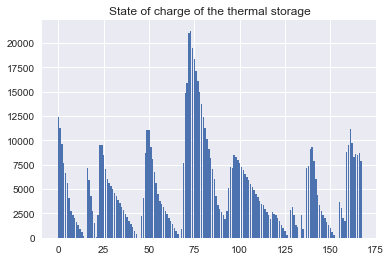

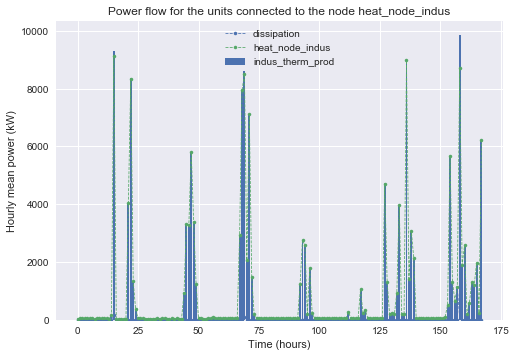

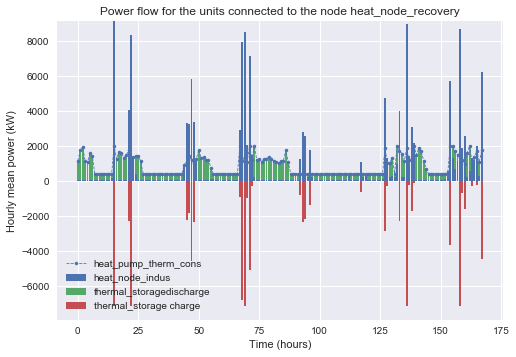

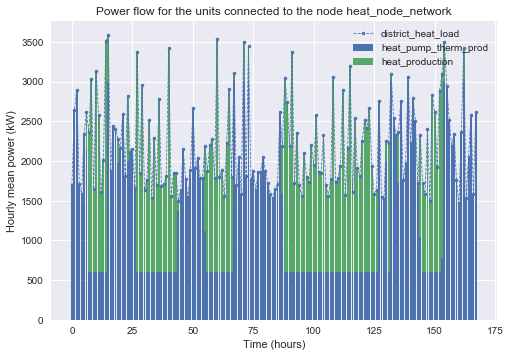

In [110]:
from omegalpes.general.utils.plots import plt, plot_quantity,\
    plot_quantity_bar, plot_node_energetic_flows

# SHOW THE GRAPH
# Storage SOC
plot_quantity_bar(time=time, quantity=thermal_storage.e,
                  title="State of charge of the thermal storage")
# Recovered and dissipated heat
plot_node_energetic_flows(heat_node_indus)

# Energy on the recovery system
plot_node_energetic_flows(heat_node_recovery)

# Energy on the district heating network
plot_node_energetic_flows(heat_node_network)

plt.show()

## Pareto chart generator example

Deleting the previous elements

In [111]:
del model, time, indus, dissipation, thermal_storage, heat_pump, district_heat_load, heat_production, electric_grid

In [112]:
OBJ = "Pareto"

# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP,
    pmax_elec_hp=P_MAX_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.


Creating and connecting the energy nodes for the energy model

In [113]:
elec_node = EnergyNode(time, 'elec_node',
                                     energy_type='Electrical')
heat_node_indus = EnergyNode(time, 'heat_node_indus',
                                     energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 'heat_node_network',
                              energy_type='Thermal')

elec_node.connect_units(electric_grid.consumption_unit, electric_grid.production_unit, heat_pump.elec_consumption_unit, indus.elec_consumption_unit)
heat_node_indus.connect_units(indus.thermal_production_unit, dissipation)
heat_node_indus.export_to_node(heat_node_recovery)
heat_node_recovery.connect_units(thermal_storage,
                                  heat_pump.thermal_consumption_unit)

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                               heat_production, district_heat_load)



Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


Adding the two antagonistic objectiuve functions

In [114]:
pareto = True

heat_production.minimize_production(weight=0.4,
                                    pareto=pareto)

thermal_storage.minimize_capacity(weight=0.6,
                                       pc_max_ratio=1 / 3,
                                       pd_max_ratio=1 / 3,
                                       pareto=pareto)

With a true pareto parameter, the solving process will launch n optimisation that depends on the *pareto_step* parameter of the *solve_and_update* method. 

In [115]:
model.add_nodes(elec_node, heat_node_indus, heat_node_recovery, heat_node_network)

model.solve_and_update(pareto_step= 0.2)

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



--- Adding all variables to the model ---
Adding variable : electric_grid_cons_p
Adding variable : electric_grid_cons_e_tot
Adding variable : electric_grid_cons_u
Adding variable : electric_grid_prod_p
Adding variable : electric_grid_prod_e_tot
Adding variable : electric_grid_prod_u
Adding variable : heat_pump_elec_cons_p
Adding variable : heat_pump_elec_cons_e_tot
Adding variable : heat_pump_elec_cons_u
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : heat_pump_COP
Adding variable : heat_pump_therm_prod_p
Adding variable : heat_pump_therm_prod_e_tot
Adding variable : heat_pump_therm_prod_u
Adding variable : heat_pump_therm_cons_p
Adding variable : heat_pump_therm_cons_e_tot
Adding variable : heat_pump_therm_cons_u
Adding variable : indus_therm_prod_p
Adding variable : indus_therm_prod_e_tot
Adding variable : indus_therm_prod_u
Adding variable : heat_node_indus_energy_export_to_heat_node_recovery
Adding variable : heat_node_indus_is_exporti


- - UPDATE RESULTS IN PARETO MODEL 1 - - 
Updating unit : elec_node
Updating unit : electric_grid_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : electric_grid_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus_elec_cons
	Quantity : p
	Quantity : e_tot
Updating unit : electric_grid
Updating unit : heat_pump
	Quantity : COP
Updating unit : indus
Updating unit : heat_pump_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_node_indus
	Quantity : energy_export_to_heat_node_recovery
	Quantity : is_exporting_to_heat_node_recovery
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_node_recovery
Updating unit : thermal_storage
	Quantity : p
	Q

**Wait for the Pareto assessement process to finish and before going any further**

Plotting the obtained Pareto front



 Preparing 2D Pareto front 


<IPython.core.display.Javascript object>


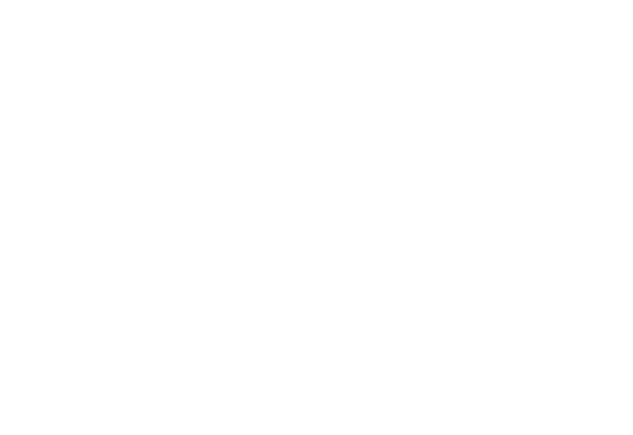

<IPython.core.display.Javascript object>


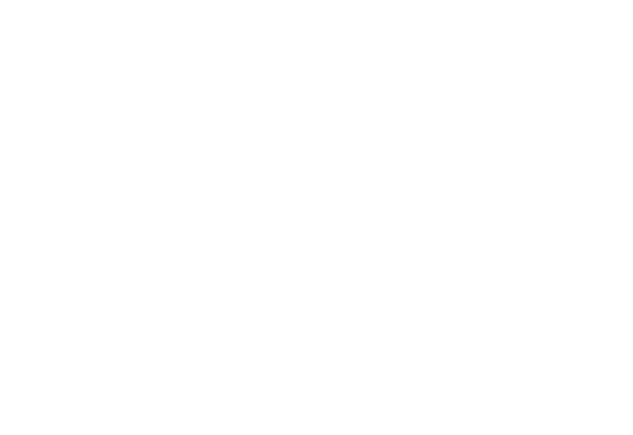

In [116]:
%matplotlib inline

from omegalpes.general.utils.plots import plot_pareto2D

plot_pareto2D(model, 
              thermal_storage.capacity, 
              heat_production.e_tot, 
              title = "Pareto between thermal capacity and heat production",  
              legend_on=False)

If the Pareto curve is not plotted for solver issues, you can find a capture of the obtained Pareto front and a Pareto step of 0.01

![Pareto](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/Pareto_waste_heat.PNG)

## Exergy module

### Modelisation of the exergy layer

Deleting the previous elements

In [30]:
del model, time, indus, dissipation, thermal_storage, heat_pump, district_heat_load, heat_production, electric_grid

In [31]:
OBJ = "exergy"
pareto = False

# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP, pmax_elec_hp=P_MAX_HP, pmin_elec_hp=P_MIN_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)

thermal_storage.minimize_capacity(weight=0.6,
                                       pc_max_ratio=1 / 3,
                                       pd_max_ratio=1 / 3,
                                       pareto=pareto)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.


Creating and connecting the energy nodes for the energy model

In [32]:
elec_node = EnergyNode(time, 'elec_node',
                                     energy_type='Electrical')
heat_node_indus = EnergyNode(time, 'heat_node_indus',
                                     energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 'heat_node_network',
                              energy_type='Thermal')

elec_node.connect_units(electric_grid.consumption_unit, electric_grid.production_unit, heat_pump.elec_consumption_unit, indus.elec_consumption_unit)
heat_node_indus.connect_units(indus.thermal_production_unit, dissipation)
heat_node_indus.export_to_node(heat_node_recovery)
heat_node_recovery.connect_units(thermal_storage,
                                  heat_pump.thermal_consumption_unit)

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                               heat_production, district_heat_load)



Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


Importing the Exergy module elements

In [33]:
from omegalpes.energy.exergy import *

For each thermal energy units Exergy classes are associted in order to evaluate their exergy destruction

In [34]:
# Exergy reference temperature
temp_ref_ex = 8

temp_wh=35

# Exergy formulation
# dissipation
ThermalExergy(energy_unit=dissipation, temp_ref=temp_ref_ex,
              temp_heat=temp_wh)
ExergyDestruction(energy_unit=dissipation, exergy_eff=0)
# storage
ThermalExergy(energy_unit=thermal_storage, temp_heat=temp_wh, temp_ref=8)
ExergyDestruction(energy_unit=thermal_storage, temp_heat=temp_wh,
                  temp_ref=8)
# heat pump
ElectricalExergy(energy_unit=heat_pump.elec_consumption_unit)
ThermalExergy(energy_unit=heat_pump.thermal_consumption_unit,
              temp_heat=temp_wh, temp_ref=8)
ThermalExergy(energy_unit=heat_pump.thermal_production_unit,
              temp_heat=85, temp_ref=8)
ExergyDestruction(energy_unit=heat_pump)
# heat load
ThermalExergy(energy_unit=district_heat_load, temp_heat=85, temp_ref=8)
ExergyDestruction(energy_unit=district_heat_load, exergy_eff=0.726)
# heat prod
ThermalExergy(energy_unit=heat_production, temp_heat=120, temp_ref=8)
ExergyDestruction(energy_unit=heat_production, exergy_eff=0.4)

Creating the thermal_exergy.
Creating the elec_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the elect_exergy.
Creating the thermal_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.
Creating the thermal_exergy.
Creating the elec_exergy.


<OMEGALPES.general.optimisation.units.OptObject: name:'elec_exergy'>

For the exergy module, one main objective is to reduce the exergy destruction while minimizing the capacity size.

In [35]:
# Exergy objectives
dissipation.minimize_exergy_destruction(weight = 0.4)
thermal_storage.minimize_exergy_destruction(weight = 0.4)
heat_pump.minimize_exergy_destruction(weight = 0.4)
heat_production.minimize_exergy_destruction(weight = 0.4)
district_heat_load.minimize_exergy_destruction(weight = 0.4)

In [36]:
model.add_nodes(elec_node, heat_node_indus, heat_node_recovery, heat_node_network)
model.solve_and_update()

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:588: UserWarning: The unit heat_pump seems to have as parent min_exergy_destruction which was not declared as parent.
  'parent.'.format(unit.name, parent_name))
c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



--- Adding all variables to the model ---
Adding variable : electric_grid_cons_p
Adding variable : electric_grid_cons_e_tot
Adding variable : electric_grid_cons_u
Adding variable : electric_grid_prod_p
Adding variable : electric_grid_prod_e_tot
Adding variable : electric_grid_prod_u
Adding variable : heat_pump_elec_cons_p
Adding variable : heat_pump_elec_cons_e_tot
Adding variable : heat_pump_elec_cons_u
Adding variable : heat_pump_elec_cons_exergy
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : heat_pump_COP
Adding variable : heat_pump_exergy_dest
Adding variable : heat_pump_exd_tot
Adding variable : heat_pump_therm_prod_p
Adding variable : heat_pump_therm_prod_e_tot
Adding variable : heat_pump_therm_prod_u
Adding variable : heat_pump_therm_prod_exergy
Adding variable : heat_pump_therm_prod_t_heat
Adding variable : heat_pump_therm_cons_p
Adding variable : heat_pump_therm_cons_e_tot
Adding variable : heat_pump_therm_cons_u
Adding variable 

### Post-treatment assessment

In [37]:
print("\n - - - - - OPTIMIZATION RESULTS - - - - - ")
print('Storage capacity = {0} kWh.'.format(
    thermal_storage.capacity.get_value()))
print('District consumption = {0} kWh.'.format(
    district_heat_load.e_tot))
print('Industry consumption = {0} kWh.'.format(
    indus.elec_consumption_unit.e_tot))
print('District heat network production = {0} kWh.'.format(
    heat_production.e_tot))
print('Industry heat exported = {0} kWh.'.format(
    sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values())))
print('Heat pump electricity consumption = {0} kWh.'.format(
    heat_pump.elec_consumption_unit.e_tot))
print("{0} % of the load coming from the industry".format(
    round(sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values()) /
          district_heat_load.e_tot.value * 100)))  # value is a dict,


 - - - - - OPTIMIZATION RESULTS - - - - - 
Storage capacity = 11018.1 kWh.
District consumption = 367860.0 kWh.
Industry consumption = 167938.5 kWh.
District heat network production = 182081.32 kWh.
Industry heat exported = 123852.45 kWh.
Heat pump electricity consumption = 61926.225 kWh.
34 % of the load coming from the industry


Considering the exergy assessment, the exergy destruction from all the concerned energy systems can be accessed, as presented in the following print.

In [38]:
print('  ')
print('--- OVERALL EXERGY DESTRUCTION BALANCE ---')
exdtot = 0
if hasattr(indus, 'exd_tot'):
    exdtot = exdtot + indus.exd_tot.value
    print('LNCMI TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(indus.exd_tot.value / 1e3, 2)))
if hasattr(dissipation, 'exd_tot'):
    exdtot = exdtot + dissipation.exd_tot.value
    print('DISSIPATION TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(dissipation.exd_tot.value / 1e3, 2)))
if hasattr(thermal_storage, 'exd_tot'):
    exdtot = exdtot + thermal_storage.exd_tot.value
    print('STORAGE TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(thermal_storage.exd_tot.value / 1e3, 5)))
if hasattr(heat_pump, 'exd_tot'):
    exdtot = exdtot + heat_pump.exd_tot.value
    print('HEAT PUMP TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(heat_pump.exd_tot.value / 1e3, 2)))
if hasattr(heat_production, 'exd_tot'):
    exdtot = exdtot + heat_production.exd_tot.value
    print('HEAT PROD TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(heat_production.exd_tot.value / 1e3, 2)))
if hasattr(heat_node_network, 'exd_tot'):
    exdtot = exdtot + heat_node_network.exd_tot.value
    print('NODE 3 TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(heat_node_network.exd_tot.value / 1e3, 2)))
if hasattr(time, 'exd_tot'):
    exdtot = exdtot + district_heat_load.exd_tot.value
    print('CONSO TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(district_heat_load.exd_tot.value / 1e3, 2)))
    print('OVERALL TOTAL EXERGY DESTRUCTION = {0} MWh'.
          format(round(exdtot / 1e3, 2)))

  
--- OVERALL EXERGY DESTRUCTION BALANCE ---
DISSIPATION TOTAL EXERGY DESTRUCTION = 2.39 MWh
STORAGE TOTAL EXERGY DESTRUCTION = 0.0 MWh
HEAT PUMP TOTAL EXERGY DESTRUCTION = 32.84 MWh
HEAT PROD TOTAL EXERGY DESTRUCTION = 77.81 MWh


Then, the exergy destruction profiles can be plotted as additionnal information.


Preparing to plot the energetic flows through the node heat_node_indus.
	Add power from indus_therm_prod.
	Add power from dissipation.
	Add power from heat_node_indus.

Preparing to plot the energetic flows through the node heat_node_recovery.
	Add power from heat_node_indus.
	Add power from thermal_storage.
	Add power from heat_pump_therm_cons.

Preparing to plot the energetic flows through the node heat_node_network.
	Add power from heat_pump_therm_prod.
	Add power from heat_production.
	Add power from district_heat_load.


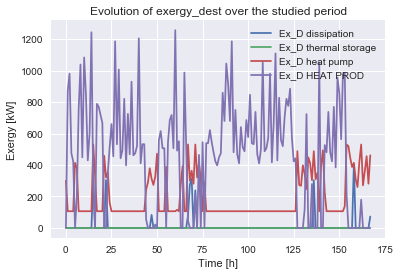

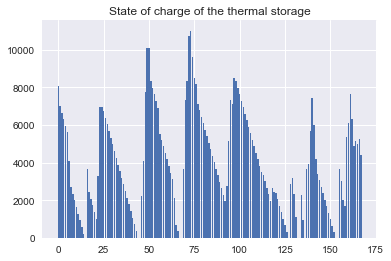

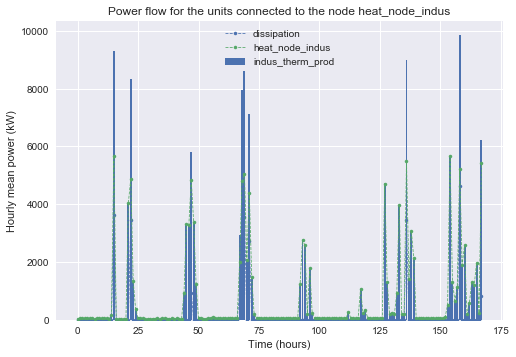

In [39]:
%matplotlib inline

# Exergy plot
fig1 = plt.figure(1)
ax1 = plt.axes()
plt.title('OVERALL EXERGY DESTRUCTION')
plt.xlabel('Time [h]')
plt.ylabel('Exergy [kW]')
legend1 = []
if hasattr(dissipation, 'exergy_dest'):
    plot_quantity(time, dissipation.exergy_dest, fig1, ax1)
    legend1 += ['Ex_D dissipation']
if hasattr(thermal_storage, 'exergy_dest'):
    plot_quantity(time, thermal_storage.exergy_dest, fig1, ax1)
    legend1 += ['Ex_D thermal storage']
if hasattr(heat_pump, 'exergy_dest'):
    plot_quantity(time, heat_pump.exergy_dest, fig1, ax1)
    legend1 += ['Ex_D heat pump']
if hasattr(heat_production, 'exergy_dest'):
    plot_quantity(time, heat_production.exergy_dest, fig1, ax1)
    legend1 += ['Ex_D HEAT PROD']
if hasattr(heat_node_network, 'exergy_dest'):
    plot_quantity(time, heat_node_network.exergy_dest, fig1, ax1)
    legend1 += ['Ex_D node 3']
if hasattr(time, 'exergy_dest'):
    plot_quantity(time, time.exergy_dest, fig1, ax1)
    legend1 += ['Ex_D district heating']
plt.legend(legend1)

plot_quantity_bar(time=time, quantity=thermal_storage.e,
                  title="State of charge of the thermal storage")
# Recovered and dissipated heat
plot_node_energetic_flows(heat_node_indus)

# Energy on the recovery system
plot_node_energetic_flows(heat_node_recovery)

# Energy on the district heating network
plot_node_energetic_flows(heat_node_network)

plt.show()

## Actor Package

In this section, the possibilities offered by the actor package are described through three scenarios.

Before adding the actor layer modelisation, the energy layer needs to be implemented similarly to the previous part.

In [40]:
del model, time, indus, dissipation, thermal_storage, heat_pump, district_heat_load, heat_production, electric_grid, 
del elec_node, heat_node_indus, heat_node_recovery, heat_node_network

In [41]:
OBJ = "actors"

# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP, pmax_elec_hp=P_MAX_HP, pmin_elec_hp=P_MIN_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.


In [42]:
elec_node = EnergyNode(time, 
                       'elec_node',
                       energy_type='Electrical')
heat_node_indus = EnergyNode(time, 
                             'heat_node_indus',
                             energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 
                                'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 
                               'heat_node_network',
                               energy_type='Thermal')

Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


### Actor scenario for thermal storage assessement 

The first scenario consists in evaluating the impact of the recovery system choice of responsability area. There are two options:

* A: the EII is the owner of the recovery system
* B: the District Heat Operator is the owner of the recovery system

Each option can be explored, with additional pareto assessment if wanted.

In [43]:
scenario = "A"
pareto = False

In [44]:
from omegalpes.actor.operator_actors.prosumer_actors import Prosumer
from omegalpes.actor.regulator_actors.regulator_actors import RegulatorActor
from omegalpes.actor.operator_actors.grid_operator_actors import HeatGridOperator

In [45]:
if scenario == "A":
    # Connecting units to the nodes
    prosumer_indus = Prosumer(name='prosumer_indus',
                                      operated_consumption_unit_list=[dissipation, indus.elec_consumption_unit,
                                                                      heat_pump.thermal_consumption_unit,
                                                                      district_heat_load],
                                      operated_production_unit_list=[indus.thermal_production_unit],
                                      operated_storage_unit_list=[thermal_storage],
                                      operated_node_list=[heat_node_indus, heat_node_recovery])
    
    heat_network_manager = HeatGridOperator('heat_grid_operator',
                                            operated_unit_list=[heat_pump.thermal_production_unit,
                                                                heat_production],
                                            operated_node_list=[heat_node_network])
    

    heat_production.minimize_production(weight=0.4,
                                        pareto=pareto)

    prosumer_indus.minimize_capacity(weight=0.6,
                                           pc_max_ratio=1 / 3,
                                           pd_max_ratio=1 / 3,
                                           max_capacity= [CAPA_STORAGE*0.8],
                                           pareto=pareto)
    # Connecting units to the nodes
    heat_node_indus.connect_units(indus.thermal_production_unit,
                                  dissipation)

    heat_node_indus.export_to_node(heat_node_recovery)  # Export after the valve
    heat_node_recovery.connect_units(thermal_storage,
                                  heat_pump.thermal_consumption_unit)

    heat_node_network.connect_units(heat_pump.thermal_production_unit,
                                    heat_production, district_heat_load)


elif scenario == "B":
    prosumer_indus = Prosumer(name='prosumer_indus',
                              operated_consumption_unit_list=[dissipation, indus.elec_consumption_unit,
                                                              heat_pump.thermal_consumption_unit,
                                                              district_heat_load],
                              operated_production_unit_list=[indus.thermal_production_unit],
                              operated_storage_unit_list=[],
                              operated_node_list=[heat_node_indus, heat_node_recovery])

    # TODO : rampe de démarrage sur le heatproduction (réel) -> contrainte avec marge de sécurité
    heat_network_manager = HeatGridOperator('heat_grid_operator',
                                            operated_unit_list=[heat_pump.thermal_production_unit,
                                                                heat_production, thermal_storage],
                                            operated_node_list=[heat_node_network])

    # Connecting units to the nodes
    heat_node_indus.connect_units(indus.thermal_production_unit,
                                  dissipation)

    heat_node_indus.export_to_node(heat_node_recovery)  # Export after the valve
    heat_node_recovery.connect_units(heat_pump.thermal_consumption_unit)

    heat_node_network.connect_units(thermal_storage,
                                    heat_pump.thermal_production_unit,
                                    heat_production, district_heat_load)

    heat_production.minimize_production(weight=0.4,
                                        pareto=pareto)

    heat_network_manager.minimize_capacity(weight=0.6,
                                           pc_max_ratio=1 / 3,
                                           pd_max_ratio=1 / 3,
                                           max_capacity=[CAPA_STORAGE],
                                           pareto=pareto)

# Adding all nodes (and connected units) to the optimization model
model.add_nodes_and_actors(heat_node_indus, heat_node_recovery, heat_node_network,
                                   prosumer_indus, heat_network_manager)

Creating the prosumer_indus.
Creating the heat_grid_operator.

--- Adding all variables to the model ---
Adding variable : heat_node_indus_energy_export_to_heat_node_recovery
Adding variable : heat_node_indus_is_exporting_to_heat_node_recovery
Adding variable : indus_therm_prod_p
Adding variable : indus_therm_prod_e_tot
Adding variable : indus_therm_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : thermal_storage_p
Adding variable : thermal_storage_e_tot
Adding variable : thermal_storage_u
Adding variable : thermal_storage_capacity
Adding variable : thermal_storage_e
Adding variable : thermal_storage_pc_max
Adding variable : thermal_storage_pd_max
Adding variable : thermal_storage_pc
Adding variable : thermal_storage_pd
Adding variable : thermal_storage_uc
Adding variable : thermal_storage_e_f
Adding variable : heat_pump_therm_cons_p
Ad

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))


In [46]:
model.solve_and_update(pareto_step= 0.1)


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 0.5474882125854492 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : heat_node_indus
	Quantity : energy_export_to_heat_node_recovery
	Quantity : is_exporting_to_heat_node_recovery
Updating unit : indus_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus
Updating unit : prosumer_indus
Updating unit : indus_elec_cons
	Quantity : p
	Quantity : e_tot
Updating unit : heat_node_recovery
Updating unit : thermal_storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc_max
	Quantity : pd_max
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump
	Quantity : COP
Updating unit : heat_pump_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat

In [47]:
print("\n - - - - - OPTIMIZATION RESULTS - - - - - ")
print('Storage capacity = {0} kWh.'.format(
    thermal_storage.capacity.get_value()))
print('District consumption = {0} kWh.'.format(
    district_heat_load.e_tot))
print('Industry consumption = {0} kWh.'.format(
    indus.elec_consumption_unit.e_tot))
print('District heat network production = {0} kWh.'.format(
    heat_production.e_tot))
print('Industry heat exported = {0} kWh.'.format(
    sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values())))
print('Heat pump electricity consumption = {0} kWh.'.format(
    heat_pump.elec_consumption_unit.e_tot))
print("{0} % of the load coming from the industry".format(
    round(sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values()) /
          district_heat_load.e_tot.value * 100)))  # value is a dict,


 - - - - - OPTIMIZATION RESULTS - - - - - 
Storage capacity = 20000.0 kWh.
District consumption = 367860.0 kWh.
Industry consumption = 167938.5 kWh.
District heat network production = 147991.93 kWh.
Industry heat exported = 146578.71689999997 kWh.
Heat pump electricity consumption = 73289.358 kWh.
40 % of the load coming from the industry


In [48]:
%matplotlib inline

if pareto == True:
    plot_pareto2D(model, 
                  thermal_storage.capacity, 
                  heat_production.e_tot, 
                  title = "Pareto between thermal capacity and heat production",  
                  legend_on=False)

### Scenario with a Regulator Actor

For this scenario, it is assumed that the choice of the person responsible for the recovery system is confirmed. It is then possible to present the functioning of the regulatory actors.

First the energy layer is loaded again.

In [49]:
del model, time, indus, dissipation, thermal_storage, heat_pump, district_heat_load, heat_production, electric_grid, 
del elec_node, heat_node_indus, heat_node_recovery, heat_node_network

In [50]:
del prosumer_indus, heat_network_manager

In [51]:
OBJ = "actors"

# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP, pmax_elec_hp=P_MAX_HP, pmin_elec_hp=P_MIN_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.


In [52]:
elec_node = EnergyNode(time, 
                       'elec_node',
                       energy_type='Electrical')
heat_node_indus = EnergyNode(time, 
                             'heat_node_indus',
                             energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 
                                'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 
                               'heat_node_network',
                               energy_type='Thermal')

Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


We are considering here a third actor, a regulator actor, who will impose constraints on heat dissipation or on CO2 emissions. One can then choose between the two scenarios and see how this affects the outcome.

In [53]:
scenario = "dissipation"

In [54]:
Regulator = RegulatorActor(name="energy_regulator")

if scenario == "dissipation":
    dissipation = VariableConsumptionUnit(time, 'dissipation',
                                          p_max = 0.0,
                                          energy_type='Thermal')
elif scenario == "CO2":
    dissipation.minimize_co2_emissions(weight=1.00, pareto=False)

Creating the energy_regulator.
Creating the dissipation.


Then the other actors are modelled on the same model than the previous part focusing on the responsability area.

In [55]:
prosumer_indus = Prosumer(name='prosumer_indus',
                          operated_consumption_unit_list=[dissipation, indus.elec_consumption_unit,
                                                          heat_pump.thermal_consumption_unit,
                                                          district_heat_load],
                          operated_production_unit_list=[indus.thermal_production_unit],
                          operated_storage_unit_list=[thermal_storage],
                          operated_node_list=[heat_node_indus, heat_node_recovery])

# TODO : rampe de démarrage sur le heatproduction (réel) -> contrainte avec marge de sécurité
heat_network_manager = HeatGridOperator('heat_grid_operator',
                                        operated_unit_list=[heat_pump.thermal_production_unit,
                                                            heat_production],
                                        operated_node_list=[heat_node_network])

heat_production.minimize_production(weight=0.4,
                                    pareto=pareto)

prosumer_indus.minimize_capacity(weight=0.6,
                                       pc_max_ratio=1 / 3,
                                       pd_max_ratio=1 / 3,
                                       max_capacity= [CAPA_STORAGE],
                                       pareto=pareto)

# Connecting units to the nodes
heat_node_indus.connect_units(indus.thermal_production_unit,
                              dissipation)

heat_node_indus.export_to_node(heat_node_recovery)  # Export after the valve
heat_node_recovery.connect_units(thermal_storage,
                              heat_pump.thermal_consumption_unit)

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                                heat_production, district_heat_load)

Creating the prosumer_indus.
Creating the heat_grid_operator.


In [56]:
# Adding all nodes (and connected units) to the optimization model
model.add_nodes_and_actors(heat_node_indus, heat_node_recovery, heat_node_network,
                                   prosumer_indus, heat_network_manager)

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



--- Adding all variables to the model ---
Adding variable : heat_node_indus_energy_export_to_heat_node_recovery
Adding variable : heat_node_indus_is_exporting_to_heat_node_recovery
Adding variable : indus_therm_prod_p
Adding variable : indus_therm_prod_e_tot
Adding variable : indus_therm_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : thermal_storage_p
Adding variable : thermal_storage_e_tot
Adding variable : thermal_storage_u
Adding variable : thermal_storage_capacity
Adding variable : thermal_storage_e
Adding variable : thermal_storage_pc_max
Adding variable : thermal_storage_pd_max
Adding variable : thermal_storage_pc
Adding variable : thermal_storage_pd
Adding variable : thermal_storage_uc
Adding variable : thermal_storage_e_f
Adding variable : heat_pump_therm_cons_p
Adding variable : heat_pump_therm_cons_e_tot
Adding variable : h

In [57]:
model.solve_and_update(pareto_step= 0.1)


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 0.4338266849517822 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : heat_node_indus
	Quantity : energy_export_to_heat_node_recovery
	Quantity : is_exporting_to_heat_node_recovery
Updating unit : indus_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus
Updating unit : prosumer_indus
Updating unit : indus_elec_cons
	Quantity : p
	Quantity : e_tot
Updating unit : heat_node_recovery
Updating unit : thermal_storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc_max
	Quantity : pd_max
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump
	Quantity : COP
Updating unit : heat_pump_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat

In [58]:
print("\n - - - - - OPTIMIZATION RESULTS - - - - - ")
print('Storage capacity = {0} kWh.'.format(
    thermal_storage.capacity.get_value()))
print('District consumption = {0} kWh.'.format(
    district_heat_load.e_tot))
print('Industry consumption = {0} kWh.'.format(
    indus.elec_consumption_unit.e_tot))
print('District heat network production = {0} kWh.'.format(
    heat_production.e_tot))
print('Industry heat exported = {0} kWh.'.format(
    sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values())))
print('Heat pump electricity consumption = {0} kWh.'.format(
    heat_pump.elec_consumption_unit.e_tot))
print("{0} % of the load coming from the industry".format(
    round(sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values()) /
          district_heat_load.e_tot.value * 100)))  # value is a dict,


 - - - - - OPTIMIZATION RESULTS - - - - - 
Storage capacity = 24885.0 kWh.
District consumption = 367860.0 kWh.
Industry consumption = 167938.5 kWh.
District heat network production = 141143.02 kWh.
Industry heat exported = 151144.64999999997 kWh.
Heat pump electricity consumption = 75572.325 kWh.
41 % of the load coming from the industry


### Scenario introducing a constraint from one actor to another one

This scenario is considering that the thermal power plants providing heat to the heat network have a average starting time of one hour, which is not simulated in the model as explained on previous part. Under these conditions, the heat network operator requires a minimum production time in order to supply heat to the network. Thus, the minimum time of production is assumes to be 2 hours. This can be a lever for negotiation between the two actors.

We consider the same energy model.

In [59]:
del model, time, indus, dissipation, thermal_storage, heat_pump, district_heat_load, heat_production, electric_grid, 
del elec_node, heat_node_indus, heat_node_recovery, heat_node_network

In [60]:
del prosumer_indus, heat_network_manager

In [61]:
OBJ = "actors"

# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP, pmax_elec_hp=P_MAX_HP, pmin_elec_hp=P_MIN_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)

heat_pump = HeatPump(time, 'heat_pump', cop=COP, pmin_in_elec = P_MIN_HP,
                                 pmax_in_elec=P_MAX_HP, min_time_on = 2)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.


In [62]:
elec_node = EnergyNode(time, 
                       'elec_node',
                       energy_type='Electrical')
heat_node_indus = EnergyNode(time, 
                             'heat_node_indus',
                             energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 
                                'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 
                               'heat_node_network',
                               energy_type='Thermal')

Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


The actors involved are then modelled, using for example the regulatory actor to complete the actor model.

In [63]:
prosumer_indus = Prosumer(name='prosumer_indus',
                          operated_consumption_unit_list=[dissipation, indus.elec_consumption_unit,
                                                          heat_pump.thermal_consumption_unit,
                                                          district_heat_load],
                          operated_production_unit_list=[indus.thermal_production_unit],
                          operated_storage_unit_list=[thermal_storage],
                          operated_node_list=[heat_node_indus, heat_node_recovery])

# TODO : rampe de démarrage sur le heatproduction (réel) -> contrainte avec marge de sécurité
heat_network_manager = HeatGridOperator('heat_grid_operator',
                                        operated_unit_list=[heat_pump.thermal_production_unit,
                                                            heat_production],
                                        operated_node_list=[heat_node_network])

heat_production.minimize_production(weight=0.4,
                                    pareto=pareto)

prosumer_indus.minimize_capacity(weight=0.6,
                                       pc_max_ratio=1 / 3,
                                       pd_max_ratio=1 / 3,
                                       max_capacity= [CAPA_STORAGE],
                                       pareto=pareto)

# Connecting units to the nodes
heat_node_indus.connect_units(indus.thermal_production_unit,
                              dissipation)

heat_node_indus.export_to_node(heat_node_recovery)  # Export after the valve
heat_node_recovery.connect_units(thermal_storage,
                              heat_pump.thermal_consumption_unit)

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                                heat_production, district_heat_load)

Creating the prosumer_indus.
Creating the heat_grid_operator.


On the actor side, the modelling consists in considering an additional parameter, which models the time constraint imposed by the heat network operator.

In [64]:
model.add_nodes_and_actors(heat_node_indus, heat_node_recovery, heat_node_network,
                               prosumer_indus, heat_network_manager)

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



--- Adding all variables to the model ---
Adding variable : heat_node_indus_energy_export_to_heat_node_recovery
Adding variable : heat_node_indus_is_exporting_to_heat_node_recovery
Adding variable : indus_therm_prod_p
Adding variable : indus_therm_prod_e_tot
Adding variable : indus_therm_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : thermal_storage_p
Adding variable : thermal_storage_e_tot
Adding variable : thermal_storage_u
Adding variable : thermal_storage_capacity
Adding variable : thermal_storage_e
Adding variable : thermal_storage_pc_max
Adding variable : thermal_storage_pd_max
Adding variable : thermal_storage_pc
Adding variable : thermal_storage_pd
Adding variable : thermal_storage_uc
Adding variable : thermal_storage_e_f
Adding variable : heat_pump_therm_cons_p
Adding variable : heat_pump_therm_cons_e_tot
Adding variable : h

In [65]:
from pulp import PULP_CBC_CMD

model.solve_and_update()


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 0.7762298583984375 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : heat_node_indus
	Quantity : energy_export_to_heat_node_recovery
	Quantity : is_exporting_to_heat_node_recovery
Updating unit : indus_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus
Updating unit : prosumer_indus
Updating unit : indus_elec_cons
	Quantity : p
	Quantity : e_tot
Updating unit : heat_node_recovery
Updating unit : thermal_storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc_max
	Quantity : pd_max
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump
	Quantity : COP
Updating unit : heat_pump_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : start_up

In [66]:
print("\n - - - - - OPTIMIZATION RESULTS - - - - - ")
print('Storage capacity = {0} kWh.'.format(
    thermal_storage.capacity.get_value()))
print('District consumption = {0} kWh.'.format(
    district_heat_load.e_tot))
print('Industry consumption = {0} kWh.'.format(
    indus.elec_consumption_unit.e_tot))
print('District heat network production = {0} kWh.'.format(
    heat_production.e_tot))
print('Industry heat exported = {0} kWh.'.format(
    sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values())))
print('Heat pump electricity consumption = {0} kWh.'.format(
    heat_pump.elec_consumption_unit.e_tot))
print("{0} % of the load coming from the industry".format(
    round(sum(
        heat_node_indus.energy_export_to_heat_node_recovery
            .value.values()) /
          district_heat_load.e_tot.value * 100)))  # value is a dict,


 - - - - - OPTIMIZATION RESULTS - - - - - 
Storage capacity = 21739.8 kWh.
District consumption = 367860.0 kWh.
Industry consumption = 167938.5 kWh.
District heat network production = 142779.75 kWh.
Industry heat exported = 150053.49999999997 kWh.
Heat pump electricity consumption = 75026.75 kWh.
41 % of the load coming from the industry


As the pump is activated throughout the two weeks, it is normal that the constraint does not change the results as it is necessarily respected. 

However, this assures the heat network manager that this constraint is respected over the time of this study.

## LPFICS package for indentification of infeasible constraints

This part focuses on the lpfics package usage. Thanks to the waste heat recovery use case and the actor layer, a infeasible problem is created in order to understand the use of lpfics package.

First it consists in ilporting the lpfics package

In [67]:
from lpfics.lpfics import *

Then we propose an infeasible problem

In [68]:
del model, time, indus, dissipation, thermal_storage, heat_pump, district_heat_load, heat_production, electric_grid

In [69]:
OBJ = "lpfics_test"
pareto = False

# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP, pmax_elec_hp=P_MAX_HP, pmin_elec_hp=P_MIN_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)


You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.


In [70]:
elec_node = EnergyNode(time, 'elec_node',
                                     energy_type='Electrical')
heat_node_indus = EnergyNode(time, 'heat_node_indus',
                                     energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 'heat_node_network',
                              energy_type='Thermal')

elec_node.connect_units(electric_grid.consumption_unit, electric_grid.production_unit, heat_pump.elec_consumption_unit, indus.elec_consumption_unit)
heat_node_indus.connect_units(indus.thermal_production_unit, dissipation)
heat_node_indus.export_to_node(heat_node_recovery)
heat_node_recovery.connect_units(thermal_storage,
                                  heat_pump.thermal_consumption_unit)

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                               heat_production, district_heat_load)

Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


The infeasible problem consists in considering a minimum capacity for thermal storage that is too low (e.g. from a choice coming from the prosumer actor).

The idea is to highlight that this capacity is too low in order to provide an optimized problem.

In [71]:
Regulator = RegulatorActor(name="energy_regulator")

dissipation = VariableConsumptionUnit(time, 'dissipation',
                                          p_max=1500,
                                          energy_type='Thermal')

# Creating the heat node for the energy flows
heat_node_indus = EnergyNode(time, 'heat_node_indus',
                             energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 'heat_node_recovery',
                                energy_type='Thermal')
heat_node_network = EnergyNode(time, 'heat_node_network',
                               energy_type='Thermal')

prosumer_indus = Prosumer(name='prosumer_indus',
                          operated_consumption_unit_list=[dissipation, indus.elec_consumption_unit,
                                                          heat_pump.thermal_consumption_unit,
                                                          district_heat_load],
                          operated_production_unit_list=[indus.thermal_production_unit],
                          operated_storage_unit_list=[thermal_storage],
                          operated_node_list=[heat_node_indus, heat_node_recovery])

# TODO : rampe de démarrage sur le heatproduction (réel) -> contrainte avec marge de sécurité
heat_network_manager = HeatGridOperator('heat_grid_operator',
                                        operated_unit_list=[heat_pump.thermal_production_unit,
                                                            heat_production],
                                        operated_node_list=[heat_node_network])
heat_production.minimize_production(weight=0.4,
                                    pareto=pareto)

prosumer_indus.minimize_capacity(weight=0.6,
                                 pc_max_ratio=1 / 3,
                                 pd_max_ratio=1 / 3,
                                 max_capacity=[CAPA_STORAGE* 0.75],
                                 pareto=pareto)

# Connecting units to the nodes
heat_node_indus.connect_units(indus.thermal_production_unit,
                              dissipation)
heat_node_recovery.connect_units(thermal_storage,
                                 heat_pump.thermal_consumption_unit)

heat_node_indus.export_to_node(heat_node_recovery)  # Export after the valve

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                                heat_production, district_heat_load)

model.add_nodes_and_actors(heat_node_indus, heat_node_recovery, heat_node_network,
                                   prosumer_indus, heat_network_manager)
model.solve_and_update()

Creating the energy_regulator.
Creating the dissipation.
Creating the heat_node_indus.
Creating the heat_node_recovery.

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



Creating the heat_node_network.
Creating the prosumer_indus.
Creating the heat_grid_operator.

--- Adding all variables to the model ---
Adding variable : heat_node_indus_energy_export_to_heat_node_recovery
Adding variable : heat_node_indus_is_exporting_to_heat_node_recovery
Adding variable : indus_therm_prod_p
Adding variable : indus_therm_prod_e_tot
Adding variable : indus_therm_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : thermal_storage_p
Adding variable : thermal_storage_e_tot
Adding variable : thermal_storage_u
Adding variable : thermal_storage_capacity
Adding variable : thermal_storage_e
Adding variable : thermal_storage_pc_max
Adding variable : thermal_storage_pd_max
Adding variable : thermal_storage_pc
Adding variable : thermal_storage_pd
Adding variable : thermal_storage_uc
Adding variable : thermal_storage_e_f
Adding var

Resolution duration = 0.33811116218566895 seconds.


/!\ Your optimization FAILED with status : Infeasible /!\.

If you want to catch the source of infeasibility:
* Please download LPFICS and use the method find_infeasible_constraint_set(your_model)
You can also use according to your needs:
- find_definition_and_actor_infeasible_constraints_set(your_model)
- find_definition_and_technical_infeasible_constraints_set(your_model)
* If you are a Gurobi user, you can also refer to the method "compute_gurobi_IIS()" in general\optimation\model.


As the problem is infeasible, the method *find_infeasible_constraint_set* can be used in order to assess the infeasible constraint

In [72]:
print(model.status)

-1


In [73]:
if LpStatus[model.status] == 'Infeasible':
    print("Sorry, the optimisation problem has no feasible solution !")
    find_definition_and_actor_infeasible_constraints_set(model)

Sorry, the optimisation problem has no feasible solution !

With LPFICS:

Testing if the project is feasible considering the actors constraints
If not, finding a set of constraints leading to the infeasibility.


The following constraints create an INFEASIBLE problem.
Becarefull, relaxing these constraints may not be enough to lead to a feasible problem. You may have to identify other constraints while relaxing these ones.
Becarefull, You should NOT release constraints of DefinitionConstraints type

Constraint type::                Constraint_name:          Constraint definition
----------------                ---------------           ---------------------
ActorConstraint ::  thermal_storage_def_min_capacity_prosumer :  thermal_storage_capacity <= 18750.0
DefinitionDynamicConstraint ::  heat_node_indus_power_balance_158 :  -dissipation_p_158 - heat_node_indus_energy_export_to_heat_node_recovery_158 + indus_therm_prod_p_158 = 0
DefinitionDynamicConstraint ::  indus_conversion_158 :  in

The output consists in a set of constraints where at least one of them is infeasible. 
Let's try to change the maximum capacity from 0.3 toi 0.6 and see if the problem remain infeasible.

In [74]:
del model, time, indus, dissipation, thermal_storage, heat_pump, district_heat_load, heat_production, electric_grid

In [75]:
OBJ = "lpfics_test"
pareto = False

# *** RUN MAIN ***
model, time, indus, dissipation, thermal_storage, heat_pump, \
district_heat_load, heat_production, electric_grid = create_energy_model_and_energy_units(
    work_path=WORK_PATH, elec2therm_ratio=ELEC_TO_HEAT_RATIO,
    pc_max=PC_MAX_STORAGE, pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
    pd_min=PD_MIN_STORAGE, self_disch_t=0.01 / 24, capa=CAPA_STORAGE,
    cop_hp=COP, pmax_elec_hp=P_MAX_HP, pmin_elec_hp=P_MIN_HP, storage_soc_0=SOC_0_STORAGE,
    temp_wh=35, obj=OBJ, scenario = SCENARIO, write_lp=False, pareto=False)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_therm_prod.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_therm_prod.
Creating the heat_pump_therm_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the electric_grid_prod.
Creating the electric_grid_cons.
Creating the electric_grid.


In [76]:
elec_node = EnergyNode(time, 'elec_node',
                                     energy_type='Electrical')
heat_node_indus = EnergyNode(time, 'heat_node_indus',
                                     energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 'heat_node_recovery',
                                 energy_type='Thermal')
heat_node_network = EnergyNode(time, 'heat_node_network',
                              energy_type='Thermal')

elec_node.connect_units(electric_grid.consumption_unit, electric_grid.production_unit, heat_pump.elec_consumption_unit, indus.elec_consumption_unit)
heat_node_indus.connect_units(indus.thermal_production_unit, dissipation)
heat_node_indus.export_to_node(heat_node_recovery)
heat_node_recovery.connect_units(thermal_storage,
                                  heat_pump.thermal_consumption_unit)

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                               heat_production, district_heat_load)

Creating the elec_node.
Creating the heat_node_indus.
Creating the heat_node_recovery.
Creating the heat_node_network.


In [77]:
Regulator = RegulatorActor(name="energy_regulator")

dissipation = VariableConsumptionUnit(time, 'dissipation',
                                          p_max=1500,
                                          energy_type='Thermal')

# Creating the heat node for the energy flows
heat_node_indus = EnergyNode(time, 'heat_node_indus',
                             energy_type='Thermal')
heat_node_recovery = EnergyNode(time, 'heat_node_recovery',
                                energy_type='Thermal')
heat_node_network = EnergyNode(time, 'heat_node_network',
                               energy_type='Thermal')

prosumer_indus = Prosumer(name='prosumer_indus',
                          operated_consumption_unit_list=[dissipation, indus.elec_consumption_unit,
                                                          heat_pump.thermal_consumption_unit,
                                                          district_heat_load],
                          operated_production_unit_list=[indus.thermal_production_unit],
                          operated_storage_unit_list=[thermal_storage],
                          operated_node_list=[heat_node_indus, heat_node_recovery])

# TODO : rampe de démarrage sur le heatproduction (réel) -> contrainte avec marge de sécurité
heat_network_manager = HeatGridOperator('heat_grid_operator',
                                        operated_unit_list=[heat_pump.thermal_production_unit,
                                                            heat_production],
                                        operated_node_list=[heat_node_network])
heat_production.minimize_production(weight=0.4,
                                    pareto=pareto)

prosumer_indus.minimize_capacity(weight=0.6,
                                 pc_max_ratio=1 / 3,
                                 pd_max_ratio=1 / 3,
                                 max_capacity=[CAPA_STORAGE],
                                 pareto=pareto)

# Connecting units to the nodes
heat_node_indus.connect_units(indus.thermal_production_unit,
                              dissipation)
heat_node_recovery.connect_units(thermal_storage,
                                 heat_pump.thermal_consumption_unit)

heat_node_indus.export_to_node(heat_node_recovery)  # Export after the valve

heat_node_network.connect_units(heat_pump.thermal_production_unit,
                                heat_production, district_heat_load)

model.add_nodes_and_actors(heat_node_indus, heat_node_recovery, heat_node_network,
                                   prosumer_indus, heat_network_manager)
model.solve_and_update()

Creating the energy_regulator.
Creating the dissipation.
Creating the heat_node_indus.
Creating the heat_node_recovery.

c:\users\brugerma\pycharmprojects\omegalpes\omegalpes\general\optimisation\model.py:575: UserWarning: The unit heat_node_indus seems to have as parent set_export_min_heat_node_recovery_min which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



Creating the heat_node_network.
Creating the prosumer_indus.
Creating the heat_grid_operator.

--- Adding all variables to the model ---
Adding variable : heat_node_indus_energy_export_to_heat_node_recovery
Adding variable : heat_node_indus_is_exporting_to_heat_node_recovery
Adding variable : indus_therm_prod_p
Adding variable : indus_therm_prod_e_tot
Adding variable : indus_therm_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : indus_elec_cons_p
Adding variable : indus_elec_cons_e_tot
Adding variable : thermal_storage_p
Adding variable : thermal_storage_e_tot
Adding variable : thermal_storage_u
Adding variable : thermal_storage_capacity
Adding variable : thermal_storage_e
Adding variable : thermal_storage_pc_max
Adding variable : thermal_storage_pd_max
Adding variable : thermal_storage_pc
Adding variable : thermal_storage_pd
Adding variable : thermal_storage_uc
Adding variable : thermal_storage_e_f
Adding var

Resolution duration = 0.5246067047119141 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : heat_node_indus
	Quantity : energy_export_to_heat_node_recovery
	Quantity : is_exporting_to_heat_node_recovery
Updating unit : indus_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : dissipation
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : indus
Updating unit : prosumer_indus
Updating unit : indus_elec_cons
	Quantity : p
	Quantity : e_tot
Updating unit : heat_node_recovery
Updating unit : thermal_storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc_max
	Quantity : pd_max
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : heat_pump_therm_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump
	Quantity : COP
Updating unit : heat_pump_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_pump_elec_cons
	Quantity : p
	Quantity 

In [78]:
print(model.status)

1


## Conclusions

This notebook allows to see all the possibilities offered by the OMEGAlpes tool in order to model and optimise a case of waste heat recovery. 

First, the energy modelling was described as well as the contributions of the exergy module. Then, an example of the use of the Pareto study creator is presented.

Finally, different scenarios of use of the actor package are presented in order to show different possibilities of use in the modelling.

Finally, the use of lpfics is described with an example highlighting its possibilities in decision support at the actor level.

## Use case factsheet

*incoming....* See [ORUCE notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/blob/master/notebooks/article_2021_BS_ORUCE.ipynb) for an example.